# Data Pipeline

ah shit, 
here we go again
{insert cj meme here}

In [53]:
from _Setup import *

In [54]:
train_data = pd.read_pickle(rawTrainFilePickle)

test_data = pd.read_pickle(rawTestFilePickle)

submission_data = pd.read_csv(rawSubmissionFile)

# Train data preparation

In [55]:
# backward fill function
def backward_fill_by_patient(df, patient_id_col='patient'):
    # Create a copy of the original DataFrame
    df_imputed = df.copy()

    df_imputed.loc[:, df_imputed.columns != patient_id_col] = (
        df_imputed.groupby(patient_id_col)
        .bfill()
    )

    # If there are patients with no entries for a column, those columns will remain unchanged
    return df_imputed

In [56]:
def forward_fill_by_patient(df, patient_id_col='patient'):
    # Create a copy of the original DataFrame
    df_imputed = df.copy()

    df_imputed.loc[:, df_imputed.columns != patient_id_col] = (
        df_imputed.groupby(patient_id_col)
        .ffill()
    )
    
    # If there are patients with no entries for a column, those columns will remain unchanged
    return df_imputed

## Remove Columns w/ > 95% initial missing values and B/F imputation

In [57]:
# Identify columns with more than 90% missing values

missing_percentage = train_data.isnull().mean() * 100

cols_to_drop_for_missing_percentage = missing_percentage[missing_percentage > 95].index

# Drop the identified columns

train_truncated = train_data.drop(columns=cols_to_drop_for_missing_percentage)

In [58]:
#forward imputation
train_forward = forward_fill_by_patient(train_truncated)
train_forward.head()

patient  time    HR  O2Sat   Temp    SBP   MAP   DBP  Resp  BaseExcess  \
0    16426     1   NaN    NaN    NaN    NaN   NaN   NaN   NaN         NaN   
1    16426     2  78.0   99.5  35.25  108.5  84.5  69.0  12.0         0.0   
2    16426     3  80.0   99.0  36.20  113.0  87.0  73.0  12.0         0.0   
3    16426     4  79.0  100.0  36.50  112.0  83.0  68.0  12.0        -2.5   
4    16426     5  73.0  100.0  36.50  115.0  80.0  64.0  11.0        -2.5   

   ...   Hgb   WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  ...   NaN   NaN        NaN  57.03     1.0    0.0    1.0        -4.25   
1  ...  12.0  14.2        NaN  57.03     1.0    0.0    1.0        -4.25   
2  ...  12.0  14.2        NaN  57.03     1.0    0.0    1.0        -4.25   
3  ...  12.0  14.2        NaN  57.03     1.0    0.0    1.0        -4.25   
4  ...  12.0  14.2        NaN  57.03     1.0    0.0    1.0        -4.25   

   ICULOS  SepsisLabel  
0     1.0          0.0  
1     2.0          0.0  
2     3.0          0.0  
3     4.0          0.0  
4     5.0          0.0  

[5 rows x 30 columns]

In [59]:
#backward imputation
pre_imputed_train = backward_fill_by_patient(train_forward)
pre_imputed_train.head()  

patient  time    HR  O2Sat   Temp    SBP   MAP   DBP  Resp  BaseExcess  \
0    16426     1  78.0   99.5  35.25  108.5  84.5  69.0  12.0         0.0   
1    16426     2  78.0   99.5  35.25  108.5  84.5  69.0  12.0         0.0   
2    16426     3  80.0   99.0  36.20  113.0  87.0  73.0  12.0         0.0   
3    16426     4  79.0  100.0  36.50  112.0  83.0  68.0  12.0        -2.5   
4    16426     5  73.0  100.0  36.50  115.0  80.0  64.0  11.0        -2.5   

   ...   Hgb   WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  ...  12.0  14.2      162.0  57.03     1.0    0.0    1.0        -4.25   
1  ...  12.0  14.2      162.0  57.03     1.0    0.0    1.0        -4.25   
2  ...  12.0  14.2      162.0  57.03     1.0    0.0    1.0        -4.25   
3  ...  12.0  14.2      162.0  57.03     1.0    0.0    1.0        -4.25   
4  ...  12.0  14.2      162.0  57.03     1.0    0.0    1.0        -4.25   

   ICULOS  SepsisLabel  
0     1.0          0.0  
1     2.0          0.0  
2     3.0          0.0  
3     4.0          0.0  
4     5.0          0.0  

[5 rows x 30 columns]

In [60]:
# Identify columns with more than 90% missing values

missing_percentage = pre_imputed_train.isnull().mean() * 100

cols_to_drop_for_missing_percentage2 = missing_percentage[missing_percentage > 80].index

print(cols_to_drop_for_missing_percentage2)

Index([], dtype='object')


## MissForest imputation

In [61]:
naPercentages = pd.DataFrame(pre_imputed_train.isna().sum() / pre_imputed_train.shape[0], columns=['Percentage'])
naPercentages.sort_values(by = ['Percentage'], ascending=False).head(10)
                             

Percentage
BaseExcess    0.637390
FiO2          0.501017
PaCO2         0.485635
pH            0.471871
Unit1         0.391502
Unit2         0.391502
DBP           0.166844
Calcium       0.096244
Magnesium     0.087443
WBC           0.041200

In [62]:
np.random.seed(8)
samplePatients = np.random.choice(pre_imputed_train['patient'].unique(), size = (10000), replace = False)

sample_pool = pre_imputed_train[pre_imputed_train['patient'].isin(samplePatients)]

sample_pool = sample_pool.drop('SepsisLabel', axis = 1)
sample_pool.shape

(386586, 29)

In [63]:
imputed_sample = pd.DataFrame(sample_pool, columns=sample_pool.columns)

imputer = MissForest()
imputer.fit(imputed_sample)

# NOTE :
This needs python 3.12 to get the .fit and .transforms funcitons on the MissForest imputer

In [64]:
imputer_input = pre_imputed_train.drop('SepsisLabel', axis = 1)
imputed_data = imputer.transform(imputer_input)

imputed_data['SepsisLabel'] = pre_imputed_train['SepsisLabel']

imputed_data.isna().sum()

100%|██████████| 5/5 [11:37<00:00, 139.54s/it]


patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
BaseExcess     0
FiO2           0
pH             0
PaCO2          0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hct            0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
SepsisLabel    0
dtype: int64

# SMOTE

In [65]:
X = imputed_data.drop(columns = ['SepsisLabel'])
y = imputed_data['SepsisLabel']


sm = SMOTE(sampling_strategy=0.3, k_neighbors=5, random_state=8)
X_train_syn, y_train_syn = sm.fit_resample(X, y)

print(imputed_data.iloc[:, 0:4].describe())
print(X_train_syn.iloc[:, 0:4].describe())

            patient          time            HR         O2Sat
count  1.088197e+06  1.088197e+06  1.088197e+06  1.088197e+06
mean   1.410742e+04  2.668297e+01  8.438115e+01  9.715170e+01
std    8.151722e+03  2.955474e+01  1.742592e+01  3.140354e+00
min    1.000000e+00  1.000000e+00  2.000000e+01  2.000000e+01
25%    7.043000e+03  1.000000e+01  7.200000e+01  9.600000e+01
50%    1.410100e+04  2.000000e+01  8.300000e+01  9.800000e+01
75%    2.118100e+04  3.400000e+01  9.500000e+01  9.900000e+01
max    2.823500e+04  4.250000e+02  2.110000e+02  1.001495e+02
            patient          time            HR         O2Sat
count  1.389147e+06  1.389147e+06  1.389147e+06  1.389147e+06
mean   1.412845e+04  3.291582e+01  8.575201e+01  9.711659e+01
std    8.159747e+03  4.027605e+01  1.793534e+01  3.179952e+00
min    1.000000e+00  1.000000e+00  2.000000e+01  2.000000e+01
25%    7.043000e+03  1.000000e+01  7.300000e+01  9.600000e+01
50%    1.416300e+04  2.200000e+01  8.450000e+01  9.800000e+01
75%    2

In [66]:
resampled_train = pd.concat([X_train_syn, y_train_syn], axis = 1)
resampled_train.head()

patient  time    HR  O2Sat   Temp    SBP   MAP   DBP  Resp  BaseExcess  \
0    16426     1  78.0   99.5  35.25  108.5  84.5  69.0  12.0         0.0   
1    16426     2  78.0   99.5  35.25  108.5  84.5  69.0  12.0         0.0   
2    16426     3  80.0   99.0  36.20  113.0  87.0  73.0  12.0         0.0   
3    16426     4  79.0  100.0  36.50  112.0  83.0  68.0  12.0        -2.5   
4    16426     5  73.0  100.0  36.50  115.0  80.0  64.0  11.0        -2.5   

   ...   Hgb   WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  ...  12.0  14.2      162.0  57.03     1.0    0.0    1.0        -4.25   
1  ...  12.0  14.2      162.0  57.03     1.0    0.0    1.0        -4.25   
2  ...  12.0  14.2      162.0  57.03     1.0    0.0    1.0        -4.25   
3  ...  12.0  14.2      162.0  57.03     1.0    0.0    1.0        -4.25   
4  ...  12.0  14.2      162.0  57.03     1.0    0.0    1.0        -4.25   

   ICULOS  SepsisLabel  
0     1.0          0.0  
1     2.0          0.0  
2     3.0          0.0  
3     4.0          0.0  
4     5.0          0.0  

[5 rows x 30 columns]

In [67]:
# Before smote distribution 
sepsis_inf = train_data['SepsisLabel'].value_counts()
sepsis_percentages = (sepsis_inf / sepsis_inf.sum()) * 100
print(sepsis_percentages)

SepsisLabel
0.0    98.196924
1.0     1.803076
Name: count, dtype: float64


In [68]:
# After smote distribution
sepsis_inf2 = resampled_train['SepsisLabel'].value_counts()
sepsis_percentages2 = (sepsis_inf2 / sepsis_inf2.sum()) * 100
print(sepsis_percentages2)

SepsisLabel
0.0    76.923105
1.0    23.076895
Name: count, dtype: float64


## Scaling 

In [69]:
# NOTE : This code is not cleaned for SepsisLabel to ensure ease of use at the test step

exclude_scaling_cols = ['patient', 'Gender', 'Unit1', 'Unit2']

# Separate columns into those to scale and those to exclude
cols_to_scale = resampled_train.drop(columns=exclude_scaling_cols + ['SepsisLabel']).columns
scaled_data = resampled_train[cols_to_scale]

# Scale the selected columns
scaler = StandardScaler()
scaled_scaled_data = pd.DataFrame(scaler.fit_transform(scaled_data), columns=cols_to_scale)

# Combine scaled data with excluded columns and the target variable
scaled_train = pd.concat([scaled_scaled_data, resampled_train[exclude_scaling_cols], resampled_train['SepsisLabel']], axis=1)

# Display the resulting DataFrame
print(scaled_train.head())

       time        HR     O2Sat      Temp       SBP       MAP       DBP  \
0 -0.792427 -0.432220  0.749512 -2.124421 -0.621283  0.146051  0.420292   
1 -0.767598 -0.432220  0.749512 -2.124421 -0.621283  0.146051  0.420292   
2 -0.742770 -0.320708  0.592277 -0.914129 -0.428503  0.299849  0.716228   
3 -0.717941 -0.376464  0.906747 -0.531932 -0.471343  0.053772  0.346308   
4 -0.693112 -0.710999  0.906747 -0.531932 -0.342823 -0.130785  0.050372   

       Resp  BaseExcess      FiO2  ...       WBC  Platelets       Age  \
0 -1.294263    0.045536  0.073114  ...  0.373687  -0.431184 -0.299413   
1 -1.294263    0.045536  0.073114  ...  0.373687  -0.431184 -0.299413   
2 -1.294263    0.045536 -0.000054  ...  0.373687  -0.431184 -0.299413   
3 -1.294263   -0.768098 -0.000054  ...  0.373687  -0.431184 -0.299413   
4 -1.479445   -0.768098 -0.014687  ...  0.373687  -0.431184 -0.299413   

   HospAdmTime    ICULOS  patient  Gender  Unit1  Unit2  SepsisLabel  
0      0.32172 -0.807406    16426     1

## Correlation Matrixes for train data set pipeline

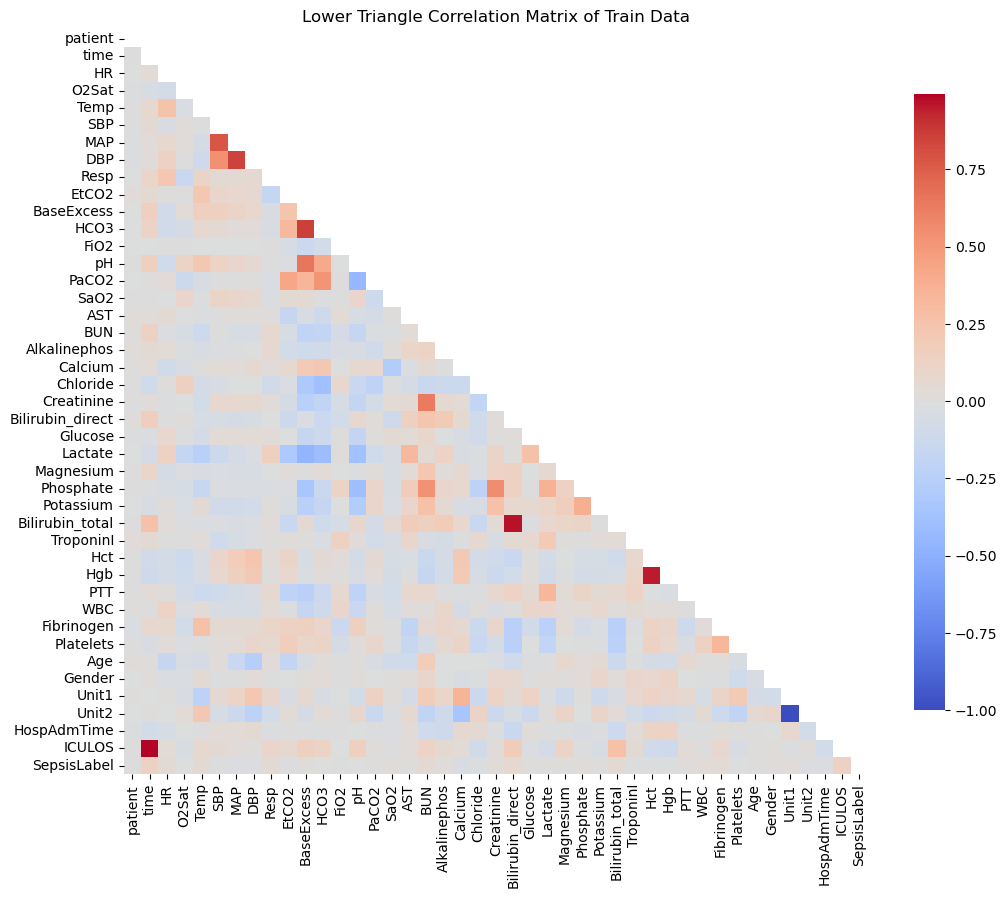

In [70]:
# TODO : Move this to the top of the file

correlation_matrix = train_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

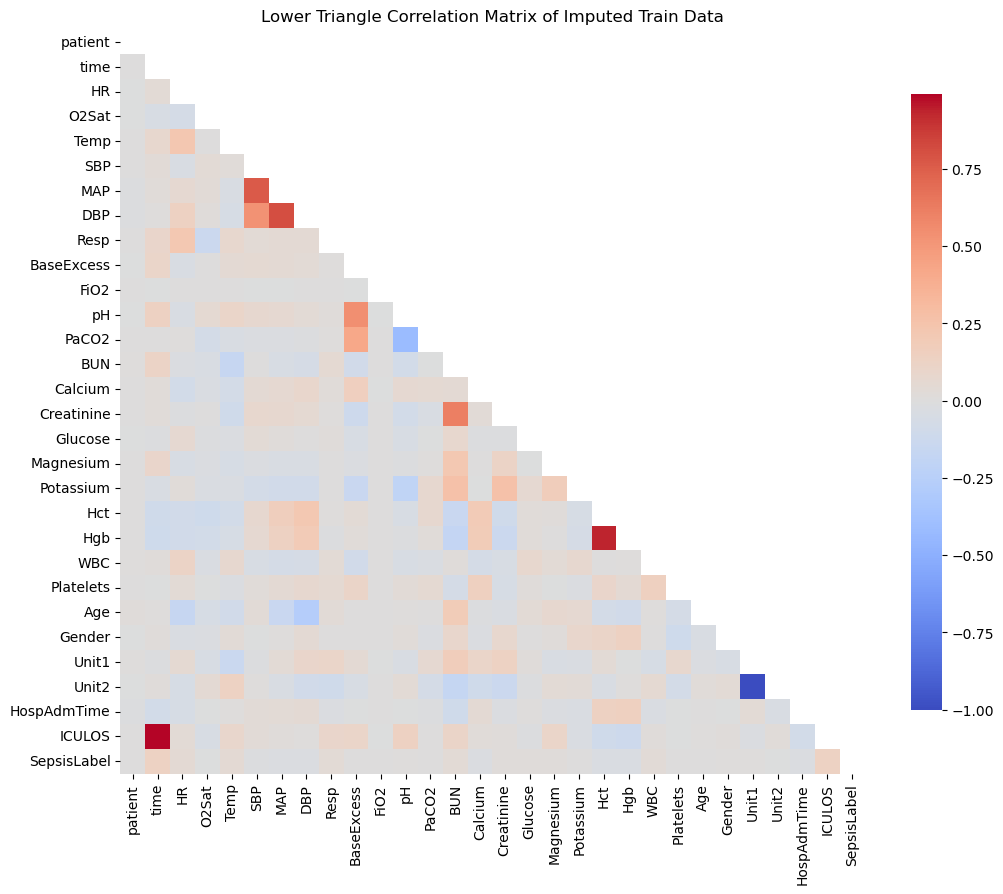

In [71]:
correlation_matrix = imputed_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Imputed Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

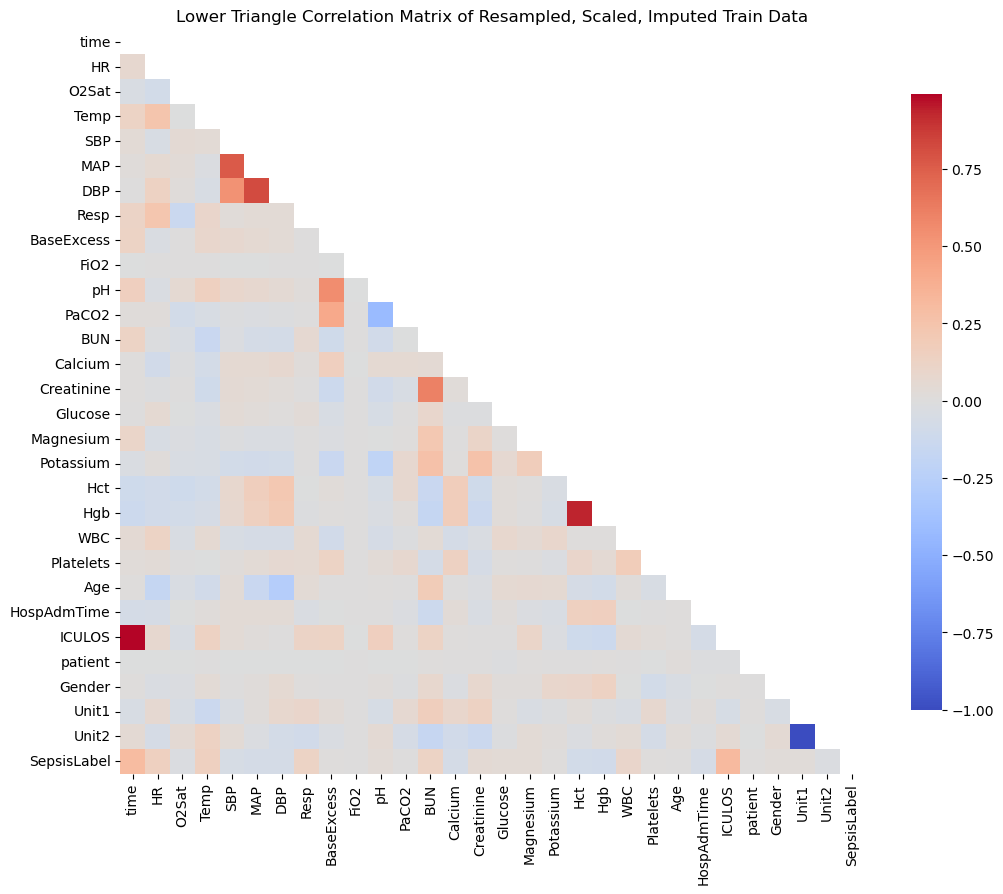

In [72]:
correlation_matrix = scaled_train.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Resampled, Scaled, Imputed Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

## Distributions for train data set pipeline

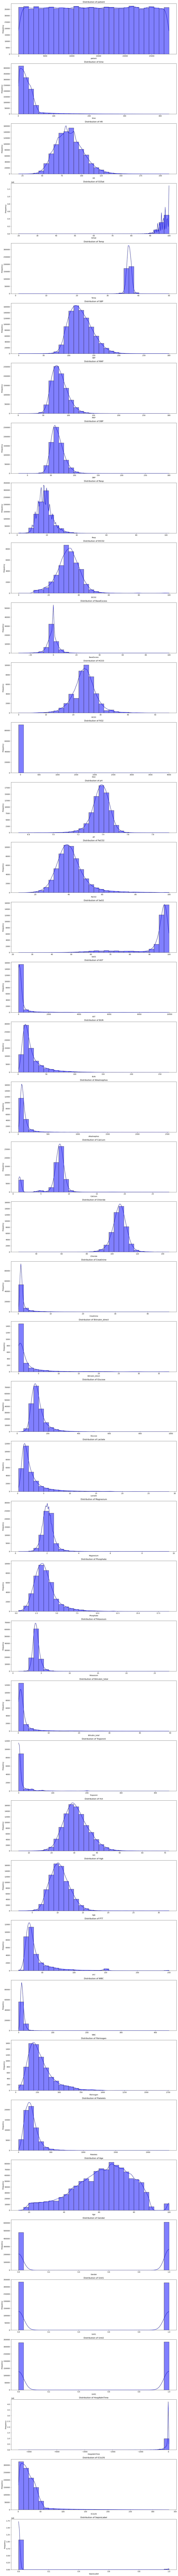

In [ ]:
def plot_all_variable_distributions(df):
    """
    Plots the distribution of all numerical variables in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    """
    
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    
    num_vars = len(num_cols)
    plt.figure(figsize=(15, 5 * num_vars))
    
    for i, col in enumerate(num_cols):
        plt.subplot(num_vars, 1, i + 1)  
        sns.histplot(df[col], kde=True, bins=30, color='blue')  
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        
    plt.tight_layout()  
    plt.show()


#plot_all_variable_distributions(train_data)

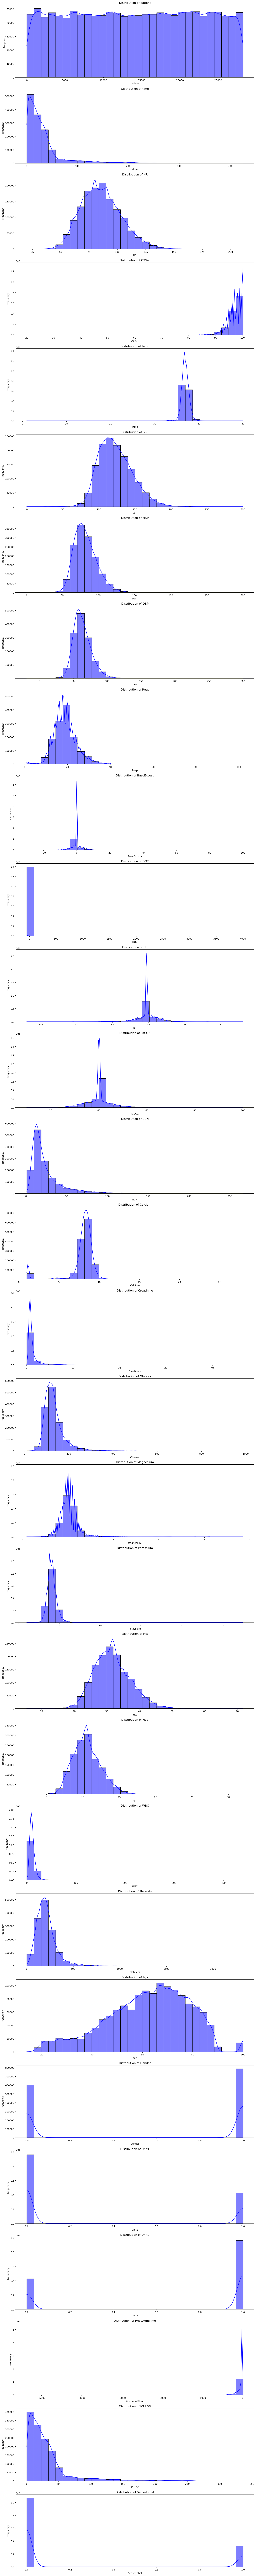

In [74]:
#plot_all_variable_distributions(resampled_train)

## Final train data set to csv

In [75]:
# get rid of the index
scaled_train.to_csv(missForestTrainFile)

# TEST PIPELINE

## Imputing B/F and missforest

In [76]:
test_dropped = test_data.drop(cols_to_drop_for_missing_percentage, axis = 1)
test_dropped.head()

patient  time     HR  O2Sat   Temp    SBP    MAP  DBP  Resp  BaseExcess  \
0     6560     1  110.0   98.0  37.67  124.0  78.00  NaN  16.0         NaN   
1     6560     2  103.0   96.0    NaN  101.0  69.67  NaN   NaN         NaN   
2     6560     3  105.0   96.0    NaN  125.0  75.67  NaN   NaN         NaN   
3     6560     4  118.0   94.0    NaN  150.0  94.67  NaN   NaN         NaN   
4     6560     5   99.0   94.0  37.50   98.0  64.00  NaN   NaN         NaN   

   ...   Hct  Hgb  WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  ...   NaN  NaN  NaN        NaN  81.64     1.0    1.0    0.0        -0.03   
1  ...  27.4  NaN  NaN        NaN  81.64     1.0    1.0    0.0        -0.03   
2  ...   NaN  NaN  NaN        NaN  81.64     1.0    1.0    0.0        -0.03   
3  ...   NaN  NaN  NaN        NaN  81.64     1.0    1.0    0.0        -0.03   
4  ...   NaN  NaN  NaN        NaN  81.64     1.0    1.0    0.0        -0.03   

   ICULOS  
0     2.0  
1     3.0  
2     4.0  
3     5.0  
4     6.0  

[5 rows x 29 columns]

In [77]:
#forward imputation
test_forward = forward_fill_by_patient(test_dropped)
test_forward.head()

patient  time     HR  O2Sat   Temp    SBP    MAP  DBP  Resp  BaseExcess  \
0     6560     1  110.0   98.0  37.67  124.0  78.00  NaN  16.0         NaN   
1     6560     2  103.0   96.0  37.67  101.0  69.67  NaN  16.0         NaN   
2     6560     3  105.0   96.0  37.67  125.0  75.67  NaN  16.0         NaN   
3     6560     4  118.0   94.0  37.67  150.0  94.67  NaN  16.0         NaN   
4     6560     5   99.0   94.0  37.50   98.0  64.00  NaN  16.0         NaN   

   ...   Hct  Hgb  WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  ...   NaN  NaN  NaN        NaN  81.64     1.0    1.0    0.0        -0.03   
1  ...  27.4  NaN  NaN        NaN  81.64     1.0    1.0    0.0        -0.03   
2  ...  27.4  NaN  NaN        NaN  81.64     1.0    1.0    0.0        -0.03   
3  ...  27.4  NaN  NaN        NaN  81.64     1.0    1.0    0.0        -0.03   
4  ...  27.4  NaN  NaN        NaN  81.64     1.0    1.0    0.0        -0.03   

   ICULOS  
0     2.0  
1     3.0  
2     4.0  
3     5.0  
4     6.0  

[5 rows x 29 columns]

In [78]:
#forward imputation
pre_imputed_test = backward_fill_by_patient(test_forward)
pre_imputed_test.head()

patient  time     HR  O2Sat   Temp    SBP    MAP  DBP  Resp  BaseExcess  \
0     6560     1  110.0   98.0  37.67  124.0  78.00  NaN  16.0         NaN   
1     6560     2  103.0   96.0  37.67  101.0  69.67  NaN  16.0         NaN   
2     6560     3  105.0   96.0  37.67  125.0  75.67  NaN  16.0         NaN   
3     6560     4  118.0   94.0  37.67  150.0  94.67  NaN  16.0         NaN   
4     6560     5   99.0   94.0  37.50   98.0  64.00  NaN  16.0         NaN   

   ...   Hct  Hgb  WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  ...  27.4  9.0  7.3      127.0  81.64     1.0    1.0    0.0        -0.03   
1  ...  27.4  9.0  7.3      127.0  81.64     1.0    1.0    0.0        -0.03   
2  ...  27.4  9.0  7.3      127.0  81.64     1.0    1.0    0.0        -0.03   
3  ...  27.4  9.0  7.3      127.0  81.64     1.0    1.0    0.0        -0.03   
4  ...  27.4  9.0  7.3      127.0  81.64     1.0    1.0    0.0        -0.03   

   ICULOS  
0     2.0  
1     3.0  
2     4.0  
3     5.0  
4     6.0  

[5 rows x 29 columns]

## Find number of missing pre-imputation

In [79]:
naPercentagesTest = pd.DataFrame(pre_imputed_test.isna().sum() / pre_imputed_test.shape[0], columns=['Percentage Test'])
naPercentagesAll = pd.concat([naPercentages, naPercentagesTest], axis = 1)
naPercentagesAll.sort_values(by = ['Percentage Test'], ascending=False).head(10)

Percentage  Percentage Test
BaseExcess    0.637390         0.636676
FiO2          0.501017         0.504755
PaCO2         0.485635         0.493645
pH            0.471871         0.479554
Unit2         0.391502         0.400408
Unit1         0.391502         0.400408
DBP           0.166844         0.167310
Calcium       0.096244         0.101265
Magnesium     0.087443         0.088816
WBC           0.041200         0.044761

In [80]:
# forward fill 
pre_imputed_test['HR'] = pd.to_numeric(pre_imputed_test['HR'], errors='coerce')

imputed_test = imputer.transform(pre_imputed_test)

100%|██████████| 5/5 [03:23<00:00, 40.77s/it]


In [81]:
imputed_test.isna().sum()

patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
BaseExcess     0
FiO2           0
pH             0
PaCO2          0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hct            0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
dtype: int64

## Scaling

In [82]:
# Separate columns into those to scale and those to exclude (no target variable in test)
cols_to_scale_test = imputed_test.drop(columns=exclude_scaling_cols).columns

# Scale the selected columns using the already-fitted scaler
scaled_test_data = pd.DataFrame(scaler.transform(imputed_test[cols_to_scale_test]), columns=cols_to_scale_test)

# Combine scaled data with excluded columns
scaled_test = pd.concat([scaled_test_data, imputed_test[exclude_scaling_cols]], axis=1)

## Correlation matrixes for test data set pipeline

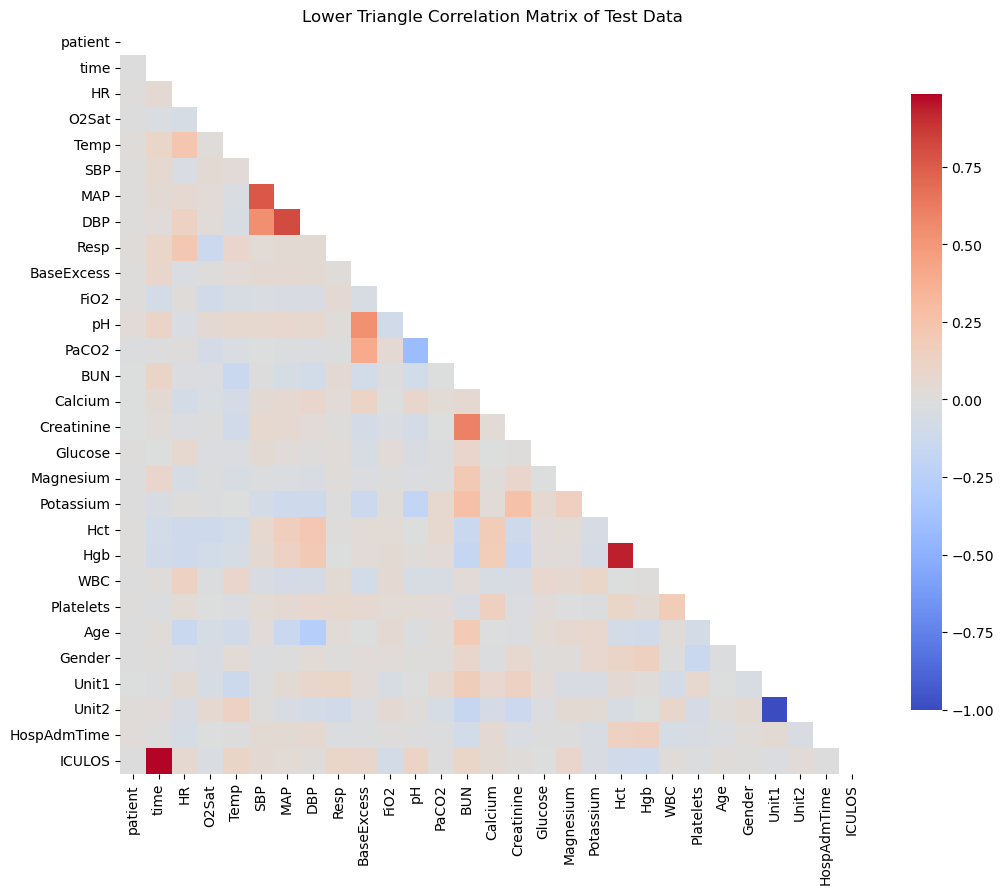

In [83]:
correlation_matrix = imputed_test.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Test Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

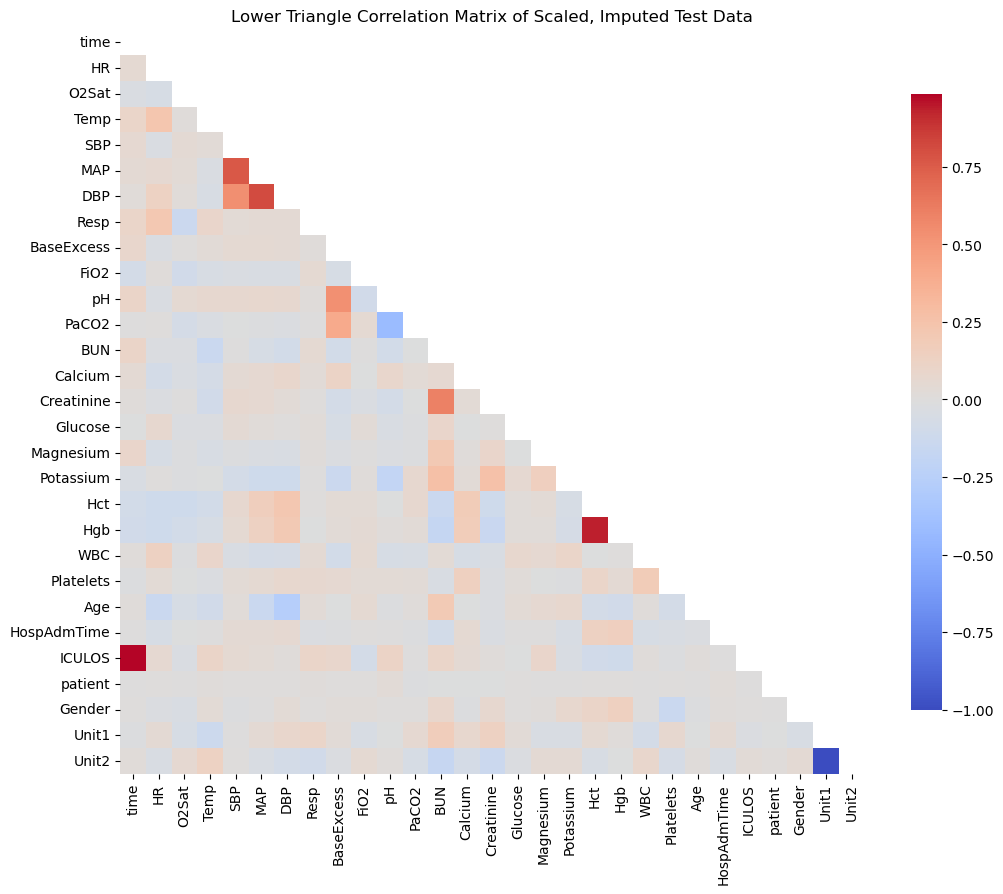

In [84]:
correlation_matrix = scaled_test.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Scaled, Imputed Test Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

## Distributions for test data pipeline

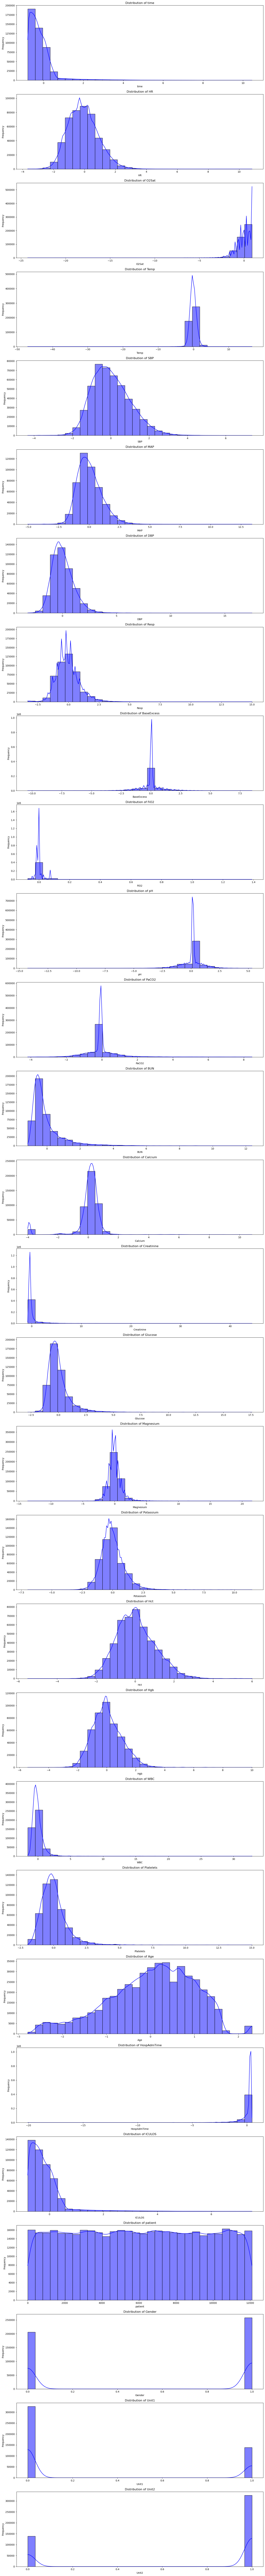

In [85]:
#plot_all_variable_distributions(scaled_test)

## Final test data set to csv 

In [86]:
#get rid of the index
scaled_test.to_csv(os.path.join(imputedDataPath, "missforest_imputed_test.csv"))